In [1]:
import os

os.environ['LD_LIBRARY_PATH'] = os.environ.get('LD_LIBRARY_PATH', '') + ':/home/drhead/miniconda3/envs/sam_hq_xla/lib'
os.environ['PT_XLA_DEBUG'] = '1' 
os.environ['PJRT_DEVICE'] = 'GPU'

# Nonzero op lowering is unstable but seems to work for some ops
# os.environ['XLA_EXPERIMENTAL'] = 'nonzero'

# Will cast ALL FLOATS to BF16
# os.environ['XLA_USE_BF16'] = '1'

import numpy as np
import torch
print("PyTorch version:", torch.__version__)
import torch_xla.core.xla_model as xm

if xm.get_xla_supported_devices("GPU") is not None:
    print("XLA GPU is available")
elif xm.get_xla_supported_devices("TPU") is not None:
    print("XLA TPU is available with ", xm.get_xla_supported_devices("TPU").count(), " cores")

import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.optim as optim
import torch.distributed as dist
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_backend
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.experimental.pjrt_backend
import torch_xla.experimental.pjrt as pjrt
import matplotlib.pyplot as plt
import cv2

# !git clone -b xla https://github.com/drhead/sam-hq.git
# os.chdir('sam-hq')
# !export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


PyTorch version: 2.0.0a0+git9cfa076
XLA GPU is available


In [2]:
# !mkdir pretrained_checkpoint
# !wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
# !mv sam_hq_vit_l.pth pretrained_checkpoint


In [12]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation'].cpu()
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

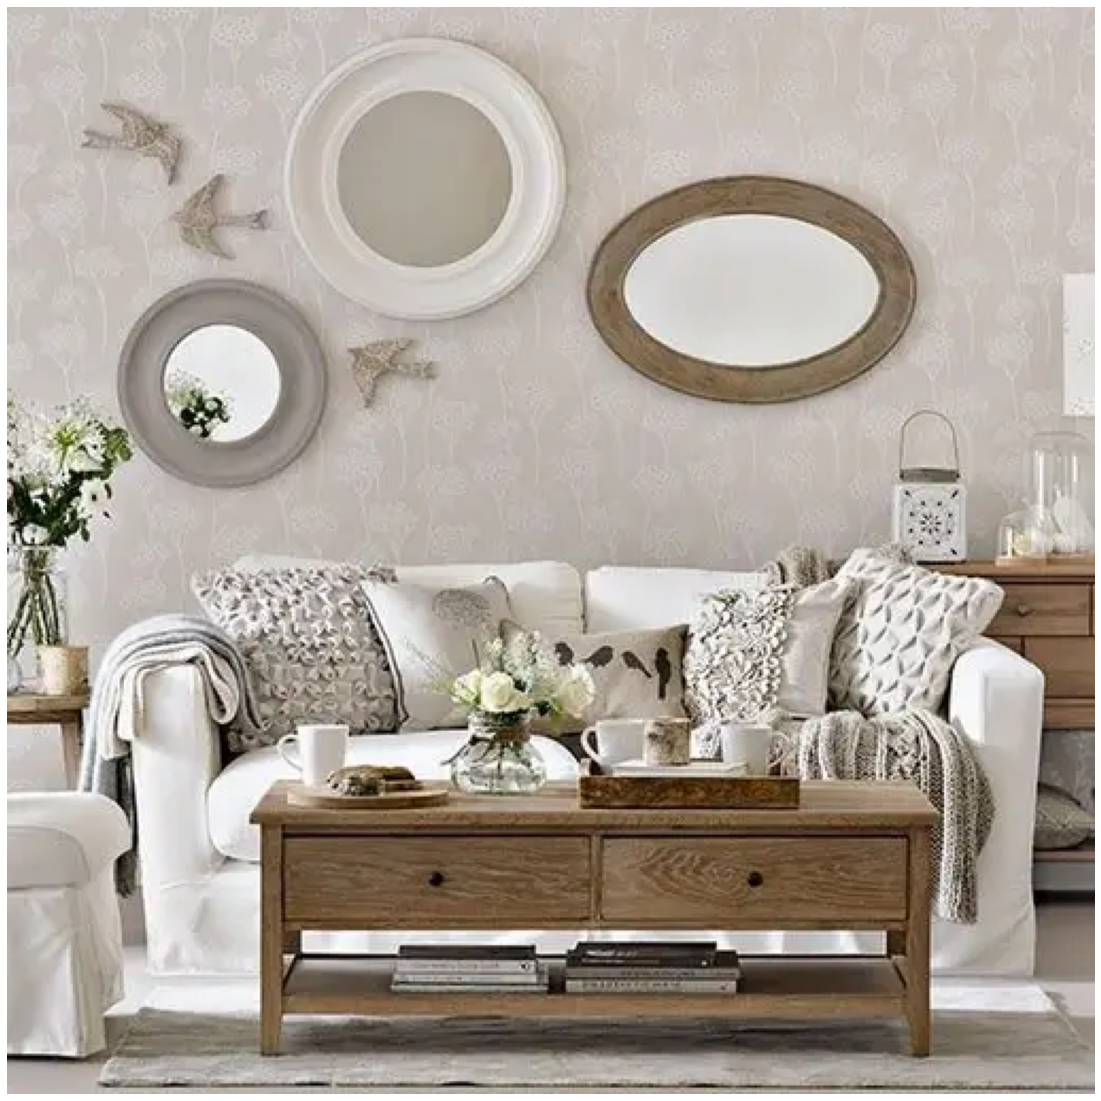

In [4]:
image = cv2.imread('data/zd_testimgs/-663378304158021540.webp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
dist.init_process_group('xla', init_method='pjrt://')

sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_h.pth"
model_type = "vit_h"
device = xm.xla_device()
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

sam.eval()
sam_dynamo = torch.compile(sam, backend='torchxla_trace_once')

mask_generator = SamAutomaticMaskGenerator(
    model=sam_dynamo,
    points_per_side=8,
    points_per_batch=64,
    min_mask_region_area=0,  # Requires open-cv to run post-processing
)

<All keys matched successfully>


In [15]:
masks = mask_generator.generate(image, multimask_output=False)
len(masks)

19

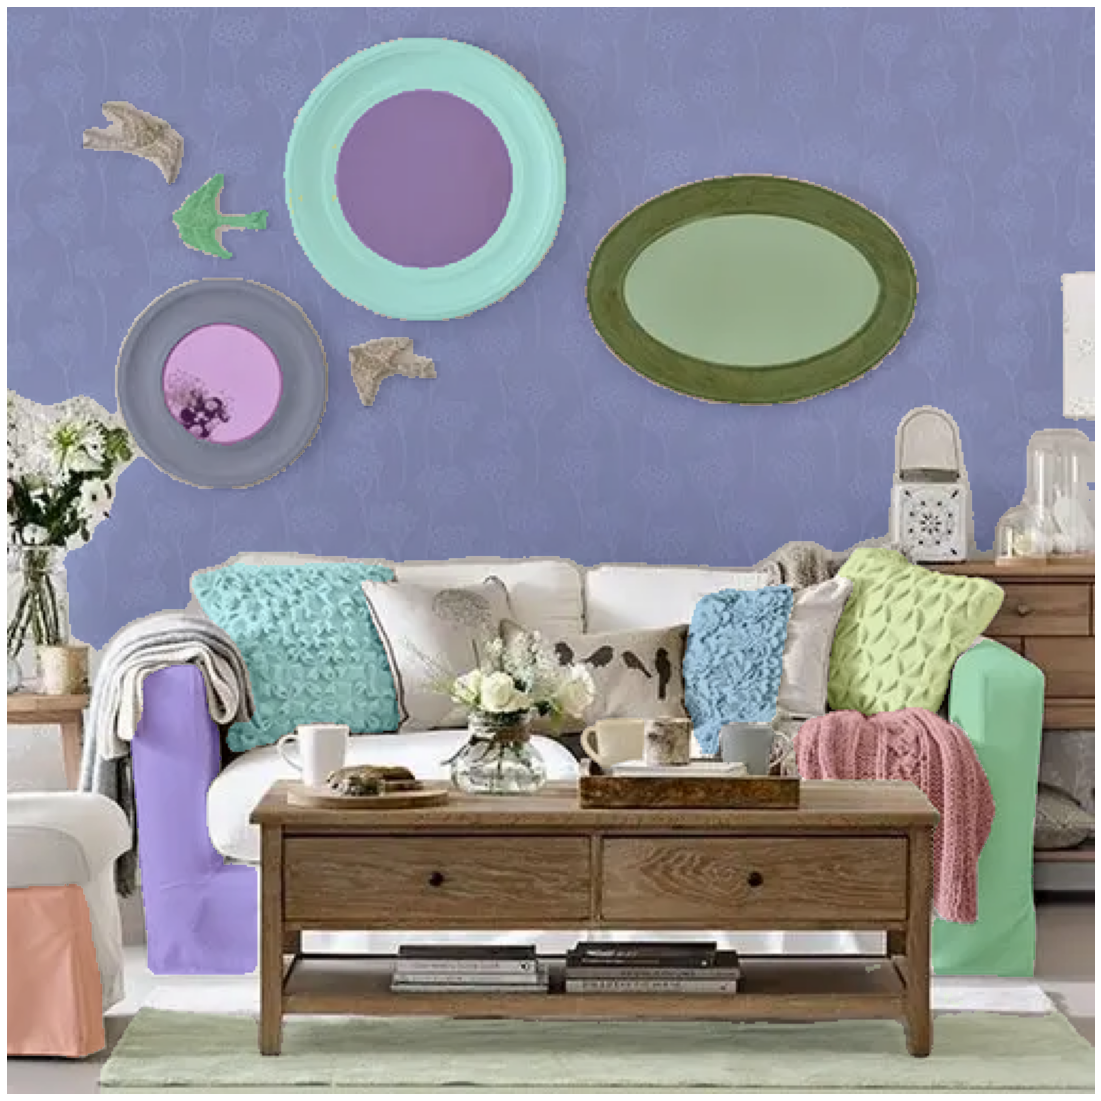

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [16]:
import torch_xla.debug.metrics as met
print(met.metrics_report())
met.clear_all()

Metric: DeviceLockWait
  TotalSamples: 118
  Accumulator: 380.100us
  ValueRate: 029.395us / second
  Rate: 9.12538 / second
  Percentiles: 1%=000.600us; 5%=000.700us; 10%=000.800us; 20%=001.100us; 50%=002.700us; 80%=005.000us; 90%=005.700us; 95%=006.200us; 99%=008.000us
Metric: IrValueTensorToXlaData
  TotalSamples: 85
  Accumulator: 005ms069.600us
  ValueRate: 001ms302.849us / second
  Rate: 21.8444 / second
  Percentiles: 1%=041.100us; 5%=042.600us; 10%=042.800us; 20%=044.600us; 50%=050.000us; 80%=066.000us; 90%=084.100us; 95%=091.900us; 99%=351.100us
Metric: TensorToData
  TotalSamples: 85
  Accumulator: 005ms676.100us
  ValueRate: 001ms201.722us / second
  Rate: 21.8444 / second
  Percentiles: 1%=037.000us; 5%=038.600us; 10%=038.800us; 20%=040.600us; 50%=045.200us; 80%=062.500us; 90%=076.500us; 95%=081.700us; 99%=348.100us
Metric: TensorsGraphSize
  TotalSamples: 58
  Accumulator: 217154.00
  ValueRate: 16793.35 / second
  Rate: 4.48536 / second
  Percentiles: 1%=3.00; 5%=3.00; 10